In [1]:
import time
import numpy as np
import gym


class MovingEnv(gym.Env):
    ACTION_NUM = 4
    MIN_POS = 0
    MAX_POS = 99
    MAX_STEPS = 100
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super().__init__()
        self.action_space = gym.spaces.Discrete(self.ACTION_NUM)
        self.observation_space = gym.spaces.Box(
            low=np.array([self.MIN_POS, self.MIN_POS]),
            high=np.array([self.MAX_POS, self.MAX_POS]),
            dtype=np.int16)

    def reset(self):
        self.pos = np.random.randint(self.MIN_POS, self.MAX_POS + 1)
        self.goal = np.random.randint(self.MIN_POS, self.MAX_POS + 1)
        self.steps = 0
        return np.array([self.goal, self.pos])

    def step(self, action):
        '''
        action
        0: -10移動
        1: -1移動
        2: +1移動
        3: +10移動
        '''
        if action == 0:
            next_pos = self.pos - 10
        elif action == 1:
            next_pos = self.pos - 1
        elif action == 2:
            next_pos = self.pos + 1
        elif action == 3:
            next_pos = self.pos + 10
        else:
            next_pos = self.pos

        if next_pos < self.MIN_POS:
            next_pos = self.MIN_POS
        elif next_pos > self.MAX_POS:
            next_pos = self.MAX_POS

        self.pos = next_pos
        self.steps += 1
        reward = 100 if self.pos == self.goal else -1
        done = True if self.pos == self.goal or self.steps > self.MAX_STEPS else False

        return np.array([self.goal, self.pos]), reward, done, {}

    def render(self, mode='human'):
        a = ['.' for x in range(self.MIN_POS, self.MAX_POS + 1)]
        a[self.goal] = 'G'
        a[self.pos] = 'o'
        print(f'\r{"".join(a)}', end='')
        time.sleep(0.1)

In [2]:
from gym.envs.registration import register

register(
    id='movingenv-v0',
    entry_point='.:MovingEnv',
)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 26s 3ms/step - reward: 2.0603
360 episodes - episode_reward: 57.275 [-101.000, 100.000] - loss: 20.443 - mae: 16.083 - mean_q: 20.880

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 28s 3ms/step - reward: 4.0904
535 episodes - episode_reward: 76.428 [-101.000, 100.000] - loss: 32.729 - mae: 55.841 - mean_q: 78.249

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 29s 3ms/step - reward: 5.0095
609 episodes - episode_reward: 82.259 [-101.000, 100.000] - loss: 18.851 - mae: 62.329 - mean_q: 85.018

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 30s 3ms/step - reward: 6.9790
797 episodes - episode_reward: 87.568 [-101.000, 100.000] - loss: 14.472 - mae: 62.087 - mean_q: 84.973

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 30s 3ms/step - reward: 7

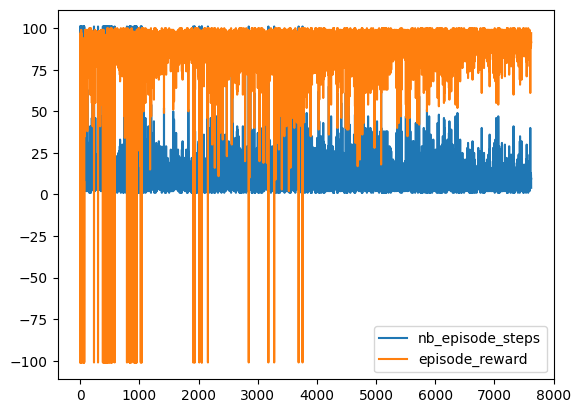

In [12]:
import gym
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

# ゲーム環境を作成します
env = MovingEnv()

# ゲーム環境を初期化します。
observation = env.reset()

# 環境からアクション数を取得します。このゲームでは4となります。
nb_actions = env.action_space.n

# Kerasを使ってモデルを作成します。
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(nb_actions, activation="linear"),
])

# 経験値を蓄積するためのメモリです。学習を安定させるために使用します。
memory = SequentialMemory(limit=50000, window_length=1)

# 行動ポリシーはBoltzmannQPolicyを使用しています。
# EpsGreedyQPolicyと比較して、こちらの方が収束が早かったので採用しています。
policy = BoltzmannQPolicy()

# DQNAgentを作成します。
dqn = DQNAgent(
    model=model,
    nb_actions=nb_actions,
    memory=memory,
    target_model_update=1e-2,
    policy=policy)

# DQNAgentのコンパイル。最適化はAdam,評価関数はMAEを使用します。
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

# 学習を開始します。100000ステップ実行します。
history = dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

# 学習した重みをファイルに保存します。
dqn.save_weights('moving_test.hdf5')

# ゲームごとのステップ数と報酬をグラフ化します。
plt.plot(history.history['nb_episode_steps'], label='nb_episode_steps')
plt.plot(history.history['episode_reward'], label='episode_reward')
plt.legend()
plt.show()


In [15]:
import gym
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

# ゲーム環境を作成します
env = MovingEnv()

# ゲーム環境を初期化します。
observation = env.reset()

nb_actions = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(nb_actions, activation="linear"),
])

memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(
    model=model,
    nb_actions=nb_actions,
    memory=memory,
    target_model_update=1e-2,
    policy=policy)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

# ↑ここまでは強化学習と同じソースです。

# 保存した重みを読み込みます。
dqn.load_weights('moving_test.hdf5')

# 5エピソード(ゲーム）実行します。
dqn.test(env, nb_episodes=5)

Testing for 5 episodes ...
..................................................................o.................................Episode 1: reward: 96.000, steps: 5
.............................................................................o......................Episode 2: reward: 99.000, steps: 2
..........................................................o.........................................Episode 3: reward: 92.000, steps: 9
...........................................................o........................................Episode 4: reward: 94.000, steps: 7
............................................................................................o.......Episode 5: reward: 96.000, steps: 5
